Import libraries

In [743]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from xgboost import plot_importance
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

Import files

In [744]:
characters = pd.read_csv("../Clean data/clean_character_data.csv")
movies = pd.read_csv("../Clean data/clean_movie_data.csv")
inputs = pd.read_csv("../Clean data/inputs.csv")

column_names = list(inputs.columns)
print(column_names)

['Wiki ID', 'Freebase ID_x', 'Movie name', 'Release date_x', 'Revenue', 'Runtime', 'IMDb rating', 'Wins', 'Nominations', 'Release year_x', 'Languages', 'Genres', 'Countries', 'United States of America-onehot', 'United Kingdom-onehot', 'India-onehot', 'Canada-onehot', 'Germany-onehot', 'Japan-onehot', 'South Korea-onehot', 'Argentina-onehot', 'France-onehot', 'United Kingodm-onehot', 'Spain-onehot', 'Ireland-onehot', 'Hong Kong-onehot', 'China-onehot', 'Russia-onehot', 'Australia-onehot', 'Italy-onehot', 'Mexico-onehot', 'New Zealand-onehot', 'Brazil-onehot', 'Belgium-onehot', 'Denmark-onehot', 'Sweden-onehot', 'Netherlands-onehot', 'Philippines-onehot', 'Thriller-onehot', 'Science Fiction-onehot', 'Horror-onehot', 'Adventure-onehot', 'Action-onehot', 'Drama-onehot', 'Comedy-onehot', 'Romance Film-onehot', 'Musical-onehot', 'Fantasy-onehot', 'Family Film-onehot', 'Crime Fiction-onehot', 'Indie-onehot', 'World cinema-onehot', 'Mystery-onehot', 'Black-and-white-onehot', 'Crime Thriller-on

Quick look at inputs

In [745]:
inputs.head()

,Wiki ID,Freebase ID_x,Movie name,Release date_x,Revenue,Runtime,IMDb rating,Wins,Nominations,Release year_x,...,Actor birth year_y,F-onehot_y,M-onehot_y,White_y,Black/African American_y,South Asian_y,East Asian_y,American Indian/Alaska Native_y,Pacific Islander_y,Other_y
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,2.315268e+07,98.0,4.9,NaN,2.0,2001,...,1969.0,0.0,1.0,0,1,0,0,0,0,0
1,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,5.8,NaN,NaN,1997,...,1964.0,1.0,0.0,0,0,0,0,0,0,1
2,171005,/m/016ywb,Henry V,1989-11-08,2.398142e+07,137.0,7.5,12.0,13.0,1989,...,1959.0,1.0,0.0,1,0,0,0,0,0,0
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,9.655040e+08,139.0,7.8,22.0,17.0,1964,...,1917.0,0.0,1.0,0,0,0,0,0,0,1
4,156558,/m/014k4y,Baby Boy,2001-06-27,4.855272e+07,123.0,6.4,1.0,14.0,2001,...,1970.0,1.0,0.0,0,1,0,0,0,0,0


In [746]:
inputs.shape

(10918, 105)

In [747]:
# Assuming 'Revenues' is the column in your DataFrame 'df'
max_revenue = inputs['Revenue'].max()
min_revenue = inputs['Revenue'].min()

print("Maximum Revenue:", max_revenue)
print("Minimum Revenue:", min_revenue)


Maximum Revenue: 9522959437.465649
Minimum Revenue: 336.5110586513585


In [748]:
# DataFrame with revenues higher than 1,000,000,000
high_revenue_df = inputs[inputs['Revenue'] > 1000000000]

# DataFrame with revenues lower than 1,000
low_revenue_df = inputs[inputs['Revenue'] < 1000000]

In [749]:
high_revenue_df.shape

(99, 105)

In [750]:
low_revenue_df.shape

(952, 105)

All inputs analysis

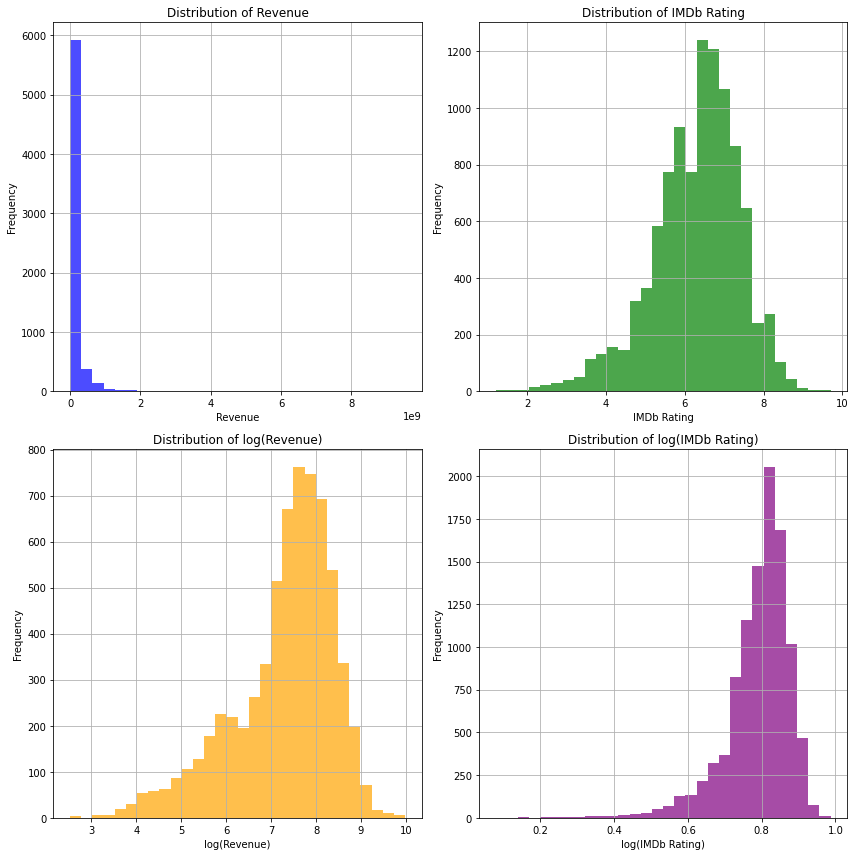

In [751]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'Revenues' and 'IMDb_Rating' are columns in your DataFrame 'df'
revenues = inputs['Revenue']
imdb_ratings = inputs['IMDb rating']

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot for Revenue
axes[0, 0].hist(revenues, bins=30, alpha=0.7, color='blue')
axes[0, 0].set_title('Distribution of Revenue')
axes[0, 0].set_xlabel('Revenue')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True)

# Plot for IMDb Rating
axes[0, 1].hist(imdb_ratings, bins=30, alpha=0.7, color='green')
axes[0, 1].set_title('Distribution of IMDb Rating')
axes[0, 1].set_xlabel('IMDb Rating')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# Plot for log-transformed Revenue
axes[1, 0].hist(np.log10(revenues), bins=30, alpha=0.7, color='orange')
axes[1, 0].set_title('Distribution of log(Revenue)')
axes[1, 0].set_xlabel('log(Revenue)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True)

# Plot for log-transformed IMDb Rating
axes[1, 1].hist(np.log10(imdb_ratings), bins=30, alpha=0.7, color='purple')
axes[1, 1].set_title('Distribution of log(IMDb Rating)')
axes[1, 1].set_xlabel('log(IMDb Rating)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True)

plt.tight_layout()  # Adjusts the spacing between plots
plt.show()


Tail-cut inputs analysis

In [752]:
min_revenue_threshold = 100000  # Set your minimum revenue threshold
max_revenue_threshold = 1000000000  # Set your maximum revenue threshold

filtered_revenues_inputs = inputs[(inputs['Revenue'] > min_revenue_threshold) & (inputs['Revenue'] < max_revenue_threshold)]

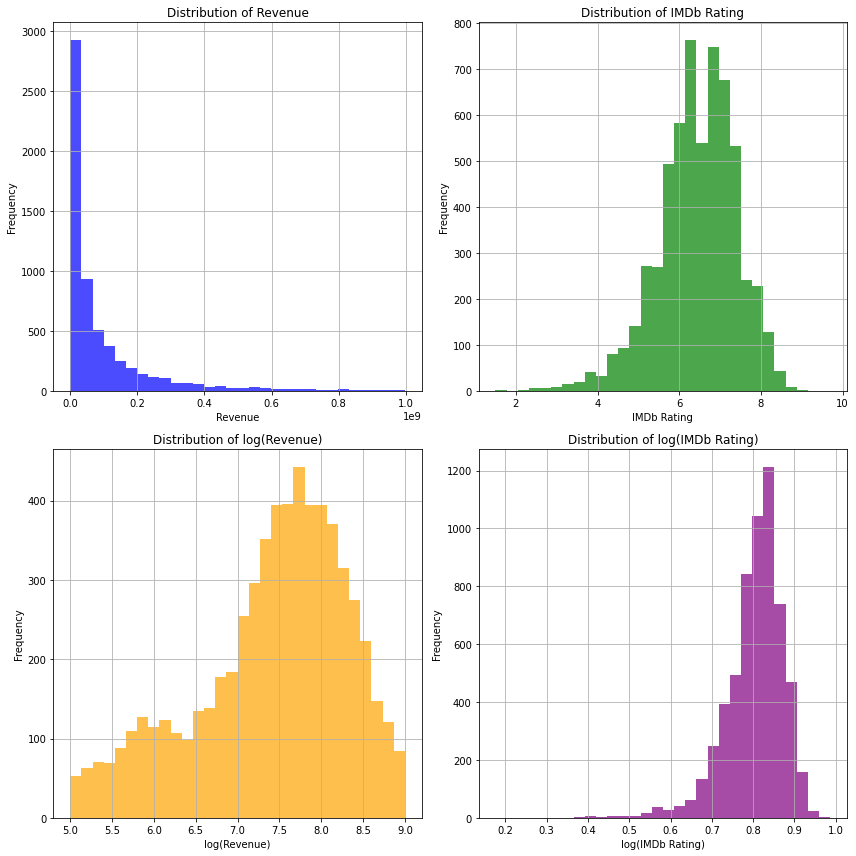

In [753]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'Revenues' and 'IMDb_Rating' are columns in your DataFrame 'df'
revenues = filtered_revenues_inputs['Revenue']
imdb_ratings = filtered_revenues_inputs['IMDb rating']

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot for Revenue
axes[0, 0].hist(revenues, bins=30, alpha=0.7, color='blue')
axes[0, 0].set_title('Distribution of Revenue')
axes[0, 0].set_xlabel('Revenue')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True)

# Plot for IMDb Rating
axes[0, 1].hist(imdb_ratings, bins=30, alpha=0.7, color='green')
axes[0, 1].set_title('Distribution of IMDb Rating')
axes[0, 1].set_xlabel('IMDb Rating')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# Plot for log-transformed Revenue
axes[1, 0].hist(np.log10(revenues), bins=30, alpha=0.7, color='orange')
axes[1, 0].set_title('Distribution of log(Revenue)')
axes[1, 0].set_xlabel('log(Revenue)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True)

# Plot for log-transformed IMDb Rating
axes[1, 1].hist(np.log10(imdb_ratings), bins=30, alpha=0.7, color='purple')
axes[1, 1].set_title('Distribution of log(IMDb Rating)')
axes[1, 1].set_xlabel('log(IMDb Rating)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True)

plt.tight_layout()  # Adjusts the spacing between plots
plt.show()


Modelling functions

In [754]:
def feat_and_target_revenue(data):
    feature = data.drop(['Revenue', 'IMDb rating'], axis = 1)
    target = np.log10(data['Revenue'])

    return feature, target

In [755]:
def feat_and_target_critics(data):
    feature = data.drop(['IMDb rating', 'Revenue'], axis = 1)
    target = (data['IMDb rating'])

    return feature, target

In [756]:
def data_splitting(feature, target):
    #Returns x_train, x_test, y_train, y_test
    return train_test_split(feature, target, test_size=0.2, random_state=42) 

In [757]:
def fit_model_revenue(model_name, xtrain, xtest, ytrain, ytest):
    if model_name == 'RandomForest':
        model = RandomForestRegressor(
    max_depth=13,
    max_features=0.5044385141334264,
    min_samples_leaf=4,
    min_samples_split=15,
    n_estimators=140,
    random_state=42
)  # Adjust parameters as needed
    elif model_name == 'XGB':
        model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree = 0.5382140919340437, 
    gamma = 1.0628444205682614,
    max_depth = 7, 
    min_child_weight = 1, 
    n_estimators = 70, 
    reg_alpha = 40
)
    elif model_name == 'GBM':
        model = GradientBoostingRegressor(
    learning_rate=0.048040737541705625,
    max_depth=4,
    min_samples_leaf=8,
    min_samples_split=5,
    n_estimators=200,
    subsample=0.7977456176958748,
    random_state=42
)

    else:
        print("Invalid model name.")
        return
    
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    mse = mean_squared_error(ytest, ypred)
    print("RMSE:", math.sqrt(mse))
    variance = ytest.std()
    print("Std:", variance)
    errors = abs(ytest - ypred)
    mean_error = np.mean(errors)
    print("Mean Absolut Error:", mean_error)

    if model_name == 'XGBoost':
        plot_importance(model, max_num_features=30)  # This function is specific to XGBoost
    else:
        # Plotting histograms for RandomForest and GBM
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].hist(ypred, bins=30, alpha=0.7, color='blue')
        axes[0].set_title('Distribution of Predictions')
        axes[0].set_xlabel('Predictions')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True)

        axes[1].hist(ytest, bins=30, alpha=0.7, color='red')
        axes[1].set_title('Actual Values')
        axes[1].set_xlabel('Values')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

    if model_name in ['RandomForest', 'XGB', 'GBM']:
        joblib.dump(model, f'{model_name}_revenue_model.pkl')
        print(f"{model_name} model trained and saved.")



In [758]:
def fit_model_critics(model_name, xtrain, xtest, ytrain, ytest):
    if model_name == 'RandomForest':
        model = RandomForestRegressor(
    max_depth=17,
    max_features=0.5013884710633058,
    min_samples_leaf=9,
    min_samples_split=14,
    n_estimators=110,
    random_state=42
)  # Adjust parameters as needed
    elif model_name == 'XGB':
        model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree = 0.8040762773750969, 
    gamma = 0.014551544273050691,
    max_depth = 7, 
    min_child_weight = 1.8067173676269164, 
    n_estimators = 200, 
    reg_alpha = 0.28332090854937586
) 
    elif model_name == 'GBM':
        model = GradientBoostingRegressor(
    learning_rate=0.058359413134240305,
    max_depth=4,
    min_samples_leaf=10,
    min_samples_split=2,
    n_estimators=150,
    subsample=0.6268043574324423,
    random_state=42
) 
    else:
        print("Invalid model name.")
        return
    
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    mse = mean_squared_error(ytest, ypred)
    print("RMSE:", math.sqrt(mse))
    variance = ytest.std()
    print("Std:", variance)
    errors = abs(ytest - ypred)
    mean_error = np.mean(errors)
    print("Mean Absolut Error:", mean_error)

    if model_name == 'XGBoost':
        plot_importance(model, max_num_features=30)  # This function is specific to XGBoost
    else:
        # Plotting histograms for RandomForest and GBM
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].hist(ypred, bins=30, alpha=0.7, color='blue')
        axes[0].set_title('Distribution of Predictions')
        axes[0].set_xlabel('Predictions')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True)

        axes[1].hist(ytest, bins=30, alpha=0.7, color='red')
        axes[1].set_title('Actual Values')
        axes[1].set_xlabel('Values')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

    if model_name in ['RandomForest', 'XGB', 'GBM']:
        joblib.dump(model, f'{model_name}_critics_model.pkl')
        print(f"{model_name} model trained and saved.")

In [759]:
def pipeline_revenue(data, model_name):
    feature, target = feat_and_target_revenue(data)
    xtrain, xtest, ytrain, ytest = data_splitting(feature, target)
    fit_model_revenue(model_name, xtrain, xtest, ytrain, ytest)
def pipeline_critics(data, model_name):
    feature, target = feat_and_target_critics(data)
    xtrain, xtest, ytrain, ytest = data_splitting(feature, target)
    fit_model_critics(model_name, xtrain, xtest, ytrain, ytest)

#'XGB': Refers to the XGBoostRegressor model.
#'RandomForest': Refers to the RandomForestRegressor model from scikit-learn.
#'GBM': Refers to the GradientBoostingRegressor model from scikit-learn.

Inputs formation

In [760]:
to_keep = ['Revenue', 'IMDb rating','M-onehot_x', 'M-onehot_y', 'Runtime', 'Release year_x', 'United States of America-onehot', 'United Kingdom-onehot', 'India-onehot', 'Canada-onehot', 'Germany-onehot', 'Japan-onehot', 'South Korea-onehot', 'Argentina-onehot', 'France-onehot', 'United Kingodm-onehot', 'Spain-onehot', 'Ireland-onehot', 'Hong Kong-onehot', 'China-onehot', 'Russia-onehot', 'Australia-onehot', 'Italy-onehot', 'Mexico-onehot', 'New Zealand-onehot', 'Brazil-onehot', 'Belgium-onehot', 'Denmark-onehot', 'Sweden-onehot', 'Netherlands-onehot', 'Philippines-onehot', 'Thriller-onehot', 'Science Fiction-onehot', 'Horror-onehot', 'Adventure-onehot', 'Action-onehot', 'Drama-onehot', 'Comedy-onehot', 'Romance Film-onehot', 'Musical-onehot', 'Fantasy-onehot', 'Family Film-onehot', 'Crime Fiction-onehot', 'Indie-onehot', 'World cinema-onehot', 'Mystery-onehot', 'Black-and-white-onehot', 'Crime Thriller-onehot', 'Actor height_x', 'Actor age at release_x', 'F-onehot_x', 'White_x', 'Black/African American_x', 'South Asian_x', 'East Asian_x', 'American Indian/Alaska Native_x', 'Pacific Islander_x', 'Other_x', 'Actor height_y', 'Actor age at release_y', 'F-onehot_y', 'White_y', 'Black/African American_y', 'South Asian_y', 'East Asian_y', 'American Indian/Alaska Native_y', 'Pacific Islander_y', 'Other_y']
#'Wins', 'Nominations','M-onehot_x', 'M-onehot_y'

all_inputs = inputs[to_keep]
inputs_filt = filtered_revenues_inputs[to_keep]

print("Number of features is: " + str(len(to_keep)))
all_inputs = all_inputs.dropna()

# List of columns to drop
columns_to_drop = ['Actor height_x', 'Actor height_y']
all_inputs.drop(columns = columns_to_drop, inplace=True)
# Dropping the specified columns
inputs_filt.drop(columns=columns_to_drop, inplace=True)
inputs_filt = inputs_filt.dropna()
play_data_bis = all_inputs.head(200)
play_data_bis.drop(columns=columns_to_drop, inplace=True)
play_data = inputs_filt.head(20)
inputs_filt = inputs_filt[20:]

print(all_inputs.shape)
print(inputs_filt.shape)


Number of features is: 68
(4753, 68)
(5496, 66)


<ipython-input-760-bfa088969cc5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs_filt.drop(columns=columns_to_drop, inplace=True)
<ipython-input-760-bfa088969cc5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play_data_bis.drop(columns=columns_to_drop, inplace=True)


In [761]:
inputs_interest = inputs[['Runtime', 'IMDb rating', 'Release year_x',
                'Adventure-onehot', 'Drama-onehot', 'Indie-onehot',
                'Actor age at release_x', 'Actor age at release_y', 'Revenue']]


nan_counts = inputs_interest.isna().sum()

for column, count in nan_counts.items():
    print(f"Column '{column}' has {count} NaN values.")

inputs_interest = inputs_interest.dropna()
print(inputs_interest.shape)

Column 'Runtime' has 622 NaN values.
Column 'IMDb rating' has 750 NaN values.
Column 'Release year_x' has 0 NaN values.
Column 'Adventure-onehot' has 0 NaN values.
Column 'Drama-onehot' has 0 NaN values.
Column 'Indie-onehot' has 0 NaN values.
Column 'Actor age at release_x' has 619 NaN values.
Column 'Actor age at release_y' has 867 NaN values.
Column 'Revenue' has 4385 NaN values.
(5875, 9)


RMSE: 0.8412237017443147
Std: 0.9612159316707036
Mean Absolut Error: 0.6494472730647342


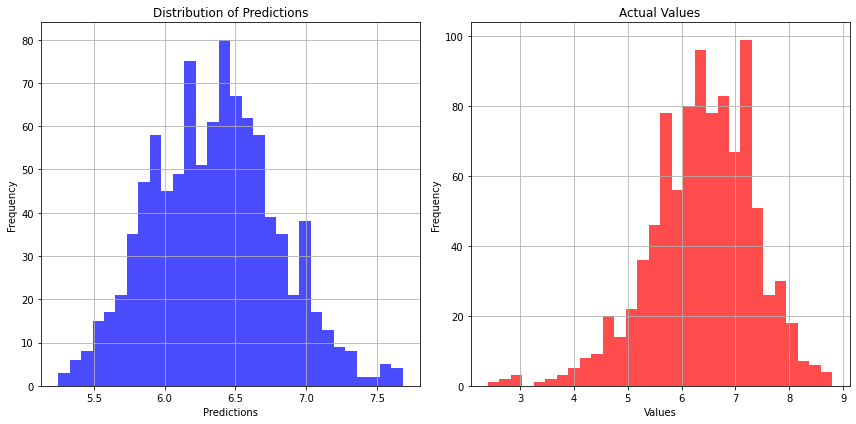

RandomForest model trained and saved.
RMSE: 0.8806682315328703
Std: 0.9612159316707036
Mean Absolut Error: 0.6883965350852028


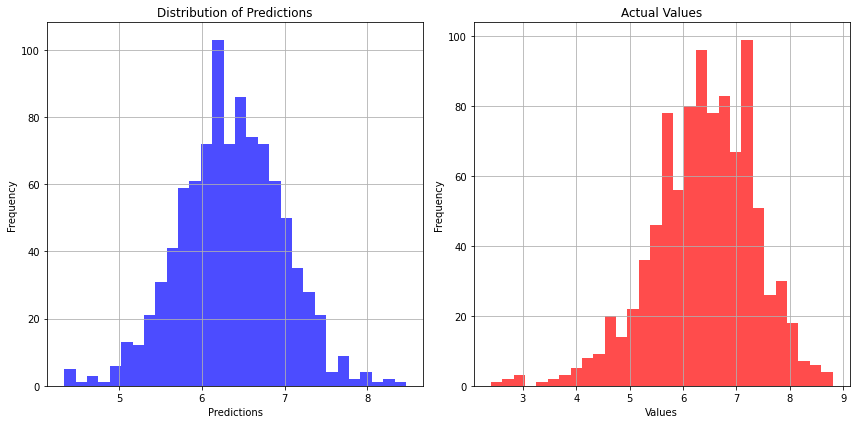

XGB model trained and saved.
RMSE: 0.8408872767016566
Std: 0.9612159316707036
Mean Absolut Error: 0.6503231675549365


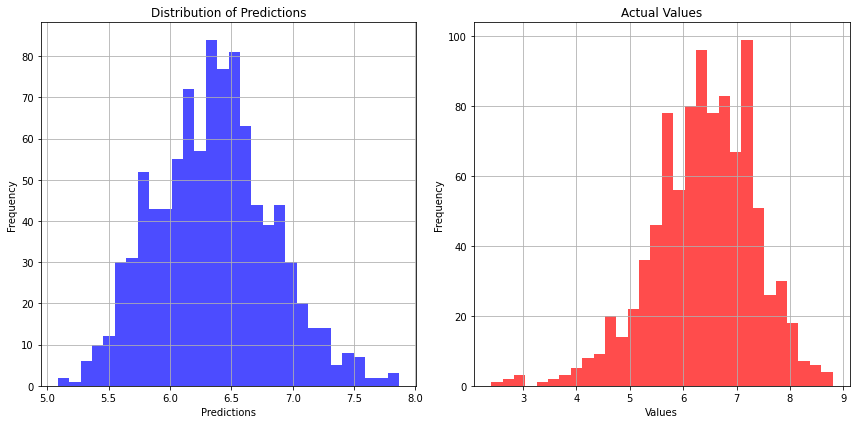

GBM model trained and saved.
RMSE: 0.8553233653639876
Std: 1.0590563403725917
Mean Absolut Error: 0.6248073637163154


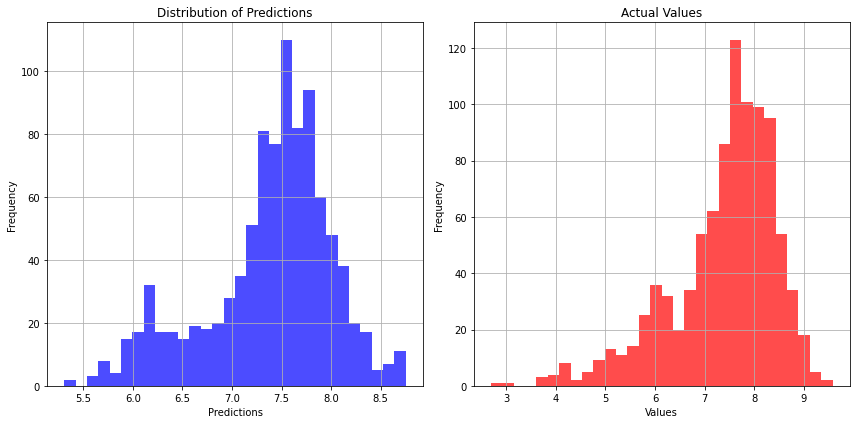

RandomForest model trained and saved.
RMSE: 0.8599733653444627
Std: 1.0590563403725917
Mean Absolut Error: 0.6389511452458863


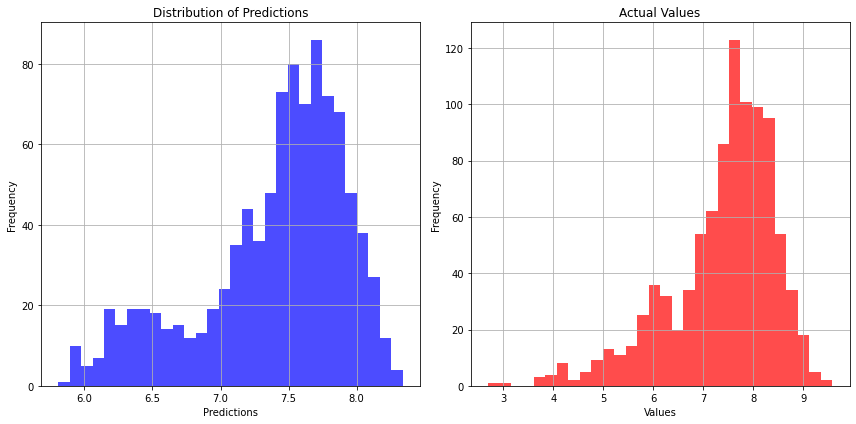

XGB model trained and saved.
RMSE: 0.8542158225665307
Std: 1.0590563403725917
Mean Absolut Error: 0.621246380298408


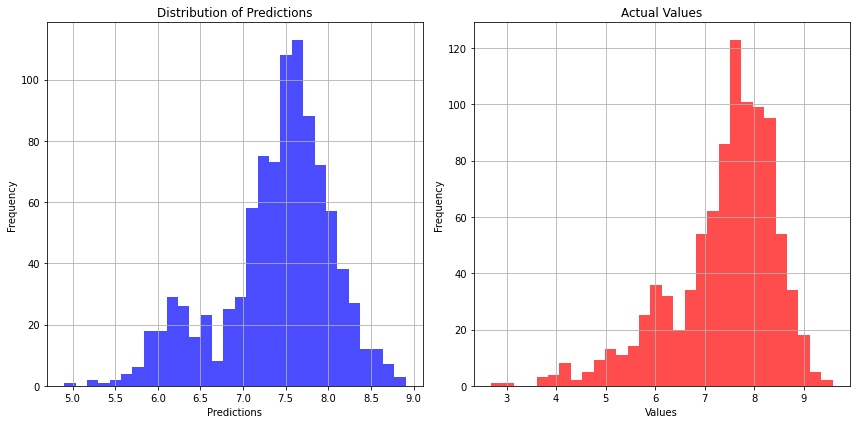

GBM model trained and saved.


In [808]:
pipeline_critics(all_inputs, 'RandomForest')
pipeline_critics(all_inputs, 'XGB')
pipeline_critics(all_inputs, 'GBM')

pipeline_revenue(all_inputs, 'RandomForest')
pipeline_revenue(all_inputs, 'XGB')
pipeline_revenue(all_inputs, 'GBM')

Hyperparameter tuning

In [809]:
space_GBM = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

In [810]:
space_RandomForest = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_features': hp.uniform('max_features', 0.5, 1)
}

In [811]:
space_XGB = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),
    'reg_lambda': hp.uniform('reg_lambda', 0, 5)
}


In [812]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import numpy as np

def hyperopt_tuning(algo_type, space, data, goal):
    if goal == 'Revenue':
        feature, target = feat_and_target_revenue(data)
    elif goal == 'Critics':
        feature, target = feat_and_target_critics(data)
    else:
        raise ValueError("Goal not understood")
    xtrain, xtest, ytrain, ytest = data_splitting(feature, target)
    def objective(space):
        if algo_type == 'XGB':
            clf = xgb.XGBRegressor(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                learning_rate=space['learning_rate'],
                subsample=space['subsample'],
                colsample_bytree=space['colsample_bytree'],
                gamma=space['gamma'],
                min_child_weight=space['min_child_weight'],
                reg_alpha=space['reg_alpha'],
                reg_lambda=space['reg_lambda']
            )
        elif algo_type == 'GBM':
            clf = GradientBoostingRegressor(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                learning_rate=space['learning_rate'],
                min_samples_split=int(space['min_samples_split']),
                min_samples_leaf=int(space['min_samples_leaf']),
                subsample=space['subsample'],
                random_state=42
            )
        elif algo_type == 'RandomForest':
            clf = RandomForestRegressor(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                min_samples_split=int(space['min_samples_split']),
                min_samples_leaf=int(space['min_samples_leaf']),
                max_features=space['max_features'],
                random_state=42
            )
        else:
            raise ValueError("Invalid algorithm type. Supported types are 'XGB', 'GBM', 'RandomForest'")
        
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        mse_scores = cross_val_score(clf, xtrain, ytrain, cv=kf, scoring='neg_mean_squared_error')
        mean_mse = np.mean(-mse_scores)
        
        return {'loss': mean_mse, 'status': STATUS_OK}
    
    trials = Trials()

    best_hyperparams = fmin(fn = objective,
                            space = space,
                            algo = tpe.suggest,
                            max_evals = 80,
                            trials = trials)

    for i, result in enumerate(trials.results):
        hyperparameters = trials.trials[i]['misc']['vals']
        score = result['loss']
        print(f"Trial {i+1}: Hyperparameters - {hyperparameters}, Score - {score}")

    
    return best_hyperparams, trials


In [813]:
#best_hyperparams, _ = hyperopt_tuning('XGB', space_XGB, inputs_filt, 'Critics')
#print("The best hyperparameters are: ", best_hyperparams)

Use models

In [814]:
def use_models_critics(data, model):
    real_ratings = data['IMDb rating']
    real_ratings = real_ratings.to_list()

    data = data.drop(['IMDb rating', 'Revenue'], axis = 1)

    if model == 'RandomForest':
        loaded_model = joblib.load('RandomForest_critics_model.pkl')
    elif model == 'XGB':
        loaded_model = joblib.load('XGB_critics_model.pkl')
    elif model == 'GBM':
        loaded_model = joblib.load('GBM_critics_model.pkl')
    else:
        raise ValueError("Invalid model type")

    unseen_data_predictions = loaded_model.predict(data)
    abs_element_wise_difference = [abs(x - y) for x, y in zip(real_ratings, unseen_data_predictions)]
    print(abs_element_wise_difference)
    list_mean = sum(abs_element_wise_difference) / len(abs_element_wise_difference)
    print(list_mean)

In [815]:
def use_models_revenue(data, model):
    real_revenue = data['Revenue']
    real_revenue = real_revenue.to_list()

    data = data.drop(['IMDb rating', 'Revenue'], axis = 1)

    if model == 'RandomForest':
        loaded_model = joblib.load('RandomForest_revenue_model.pkl')
    elif model == 'XGB':
        loaded_model = joblib.load('XGB_revenue_model.pkl')
    elif model == 'GBM':
        loaded_model = joblib.load('GBM_revenue_model.pkl')
    else:
        raise ValueError("Invalid model type")

    unseen_data_predictions = np.power(10, loaded_model.predict(data))
    abs_element_wise_difference = [abs(x - y) for x, y in zip(real_revenue, unseen_data_predictions)]
    print(abs_element_wise_difference)
    list_mean = sum(abs_element_wise_difference) / len(abs_element_wise_difference)
    print(list_mean)

In [816]:
use_models_critics(play_data_bis, 'RandomForest')

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Actor height_x
- Actor height_y


In [ ]:
use_models_critics(play_data_bis, 'XGB')

[0.9074107170104977, 0.004844188690185547, 0.06375656127929652, 0.7440923690795902, 0.1965479850769043, 0.4739636421203617, 2.202563762664795, 0.10377397537231481, 0.14336795806884783, 0.7649015426635746, 0.07726984024047834, 1.576129055023193, 0.4687337875366211, 0.3612337112426758, 0.17922687530517578, 0.7749308586120609, 0.770197105407715, 0.1462884902954098, 0.13168163299560565, 0.04458837509155256, 0.07334327697753906, 0.41589374542236346, 0.5880960464477543, 0.060192108154296875, 0.14790115356445277, 0.11497735977172852, 0.22934312820434588, 0.010037803649902699, 0.07117996215820277, 0.8394879341125492, 0.08978939056396484, 0.09232587814331072, 0.28570480346679705, 1.031704616546631, 0.27211818695068324, 0.18579416275024396, 0.07877330780029279, 0.1508567810058592, 0.019740676879882457, 0.2505838394165041, 0.964619827270508, 0.08533153533935511, 0.1355502128601076, 0.5662283897399902, 0.6829221725463865, 0.13469705581665004, 0.42090320587158203, 0.2762323379516598, 0.647662639617

In [ ]:
use_models_critics(play_data_bis, 'GBM')

[0.5520483104219993, 0.2798769191394044, 0.20792305785873655, 0.7506706539751162, 0.02920301612444831, 0.7603883332647046, 1.1562153536212447, 0.35867277050052593, 0.27090301906145076, 0.44196422615423536, 0.4893351254121523, 1.0386341645626533, 0.16467444119944474, 0.42840830109537986, 0.3066318933277774, 0.3859251599392266, 0.39097693742691586, 1.5816023502556975, 0.015087993962461077, 0.34296037289020553, 0.08019909118094493, 1.0282909372369797, 1.1921874828075198, 0.0881305602433109, 0.20541855929884534, 0.20987524342477393, 0.06673968741360081, 0.6832715617752152, 0.10128091244812776, 0.9544337950661124, 0.15131319116733621, 0.1811362340739313, 1.071384944956563, 0.9071513721173945, 0.3598157482944906, 1.010589060012279, 0.5603684955401951, 1.9647027115950442, 0.41213689436119605, 0.5058786414623553, 0.18754687292047123, 0.21365588040574846, 0.37320569272385473, 0.5594615130560596, 0.8336608335814022, 0.11631752094802117, 1.4652805282767947, 0.46796414031728517, 0.9876824219543794

In [ ]:
use_models_revenue(play_data_bis, 'RandomForest')

[36045485.08155681, 590532.1059298068, 18299527.311702676, 1862250.0353168822, 37766207.2842034, 8470171.547596741, 2024749.3560215477, 64261740.92929958, 12103674.293453412, 31733923.72344993, 1625901476.188301, 25086062.201613262, 38057332.967721224, 46336436.58118539, 122591092.67671368, 1152669761.2304423, 22200274.50680531, 1471757.6043516737, 9633131.8930763, 154391673.14619052, 2856944.9083836265, 34001332.03327728, 1613621.9706217875, 188823768.20253342, 536839.0820297189, 21906273.351522423, 8235867.093544812, 31691805.162121877, 6098835.3913837075, 30852010.75554253, 20881668.10313363, 13698995.224150307, 10418419.89314996, 20393353.758234072, 29297732.434396025, 23085309.22448443, 29823145.569190312, 829996.143287531, 141423483.8932854, 64944952.29923161, 389998.8785019077, 171549.06707367627, 595626718.6301672, 118397047.76297046, 20269958.723711945, 7001539.201648066, 16335822.026482234, 10041320.282775344, 7370282.408184081, 86319478.92937806, 592746059.2618103, 22684331.

In [ ]:
use_models_revenue(play_data_bis, 'XGB')

[21537861.67950311, 11813377.805201609, 4101789.2642857134, 2506626.345114087, 25005797.208185486, 12487969.259786472, 2120410.9398369566, 70261222.18181819, 9655307.81892361, 23571397.687407404, 1662393097.8503065, 27818973.196211066, 44563722.48062621, 36902532.07058824, 120238120.68711653, 1181152531.7329752, 21397945.191619936, 2767336.7080730544, 3850703.938839942, 171943189.6963471, 4165744.502815392, 34018109.11866042, 2784104.9194478528, 184160508.02250335, 10803269.500044014, 8855031.564675754, 9024818.638878267, 47286689.58935484, 1288534.0080392137, 15232777.84175378, 7659034.408823527, 4406219.856115095, 5720805.732837539, 24443456.170394737, 21623207.21095818, 51988206.56338583, 41064040.79317699, 2082839.7431550268, 143355071.8937601, 70649469.65932132, 1282360.0932930708, 1275126.3627329194, 618126657.7548473, 112682755.25968844, 32795168.347601246, 20350008.43445693, 23653811.079365082, 18620116.358918004, 13510565.3922913, 93099480.51748171, 576991494.7096773, 17727401

In [ ]:
use_models_revenue(play_data_bis, 'GBM')

[45961863.090858996, 5206603.993063975, 3668589.8154627234, 1297276.2694032756, 29206389.943815835, 6562931.761348933, 2729917.581542198, 76026835.65981103, 13045248.974075697, 28324994.315660812, 1547521361.0581858, 30007056.40995953, 41297844.36203665, 21281128.772174723, 95810051.3336761, 1064483844.1638862, 19897006.556836046, 1566461.803106255, 9562533.349198833, 165610786.98718718, 5116365.808785653, 42891142.730529256, 1940106.3823952286, 190341589.71173695, 5165286.772114847, 22620640.385517165, 5665425.733697486, 28846087.629973277, 6618066.007338479, 9245950.450850919, 17449833.620437976, 15367646.07366971, 8648287.272665698, 14700097.900021458, 35943450.40166787, 57160104.978856206, 66218814.67404943, 1017970.4395543813, 142736082.826026, 65875984.59542697, 344532.4584897865, 77960.13877448416, 624015696.280947, 137410366.06747615, 22288699.69172819, 16452414.599785807, 16159437.696604738, 12038798.653179359, 7457286.697545305, 82706854.4774285, 532248730.12524855, 15815711.